In [2]:
import os
import pickle
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add, RepeatVector, TimeDistributed

In [3]:
path= "/kaggle/input/flickr30k"

In [4]:
# -------------------------------
# 1. SET PATH
# -------------------------------
IMAGE_DIR = os.path.join(path, "Images")
CAPTION_FILE = os.path.join(path, "captions.txt")

print("Dataset contents:")
print("  • Image directory:", IMAGE_DIR)
print("  • Caption file:", CAPTION_FILE)
# -------------------------------
def load_captions(caption_file):
    image_captions = {}
    with open(caption_file, 'r') as f:
        next(f)  # skip header
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) != 2:
                continue
            img_name, caption = parts
            caption = caption.lower().strip()

            if img_name not in image_captions:
                image_captions[img_name] = []
            image_captions[img_name].append(caption)
    return image_captions

image_captions = load_captions(CAPTION_FILE)
print(f"Loaded {len(image_captions)} images with captions.")


Dataset contents:
  • Image directory: /kaggle/input/flickr30k/Images
  • Caption file: /kaggle/input/flickr30k/captions.txt
Loaded 31783 images with captions.


In [5]:
# -------------------------------
# 3. PREPROCESS IMAGES FOR ResNet50
# -------------------------------
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

# -------------------------------
# 4. TOKENIZER & PREPARE CAPTIONS
# -------------------------------
all_captions = []
for caps in image_captions.values():
    all_captions.extend([f"startseq {c} endseq" for c in caps])

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

max_caption_length = max(len(c.split()) for c in all_captions)
print(f"Max caption length: {max_caption_length}")

Vocabulary size: 18316
Max caption length: 85


In [6]:
# -------------------------------
# 5. BUILD CNN ENCODER (ResNet50)
# -------------------------------
encoder = ResNet50(weights='imagenet', include_top=False, pooling='avg')
encoder = Model(encoder.input, encoder.output)
encoder.trainable = False
print("Encoder ready → feature dim:", 2048)

# -------------------------------
# 6. EXTRACT IMAGE FEATURES (once)
# -------------------------------
FEATURES_PATH = "flickr30k_features_resnet50.pkl"

if not os.path.exists(FEATURES_PATH):
    print("Extracting features for all images...")
    features = {}
    img_names = list(image_captions.keys())

    for img_name in tqdm(img_names, desc="Extracting"):
        img_path = os.path.join(IMAGE_DIR, img_name)
        if not os.path.exists(img_path):
            continue
        img_array = preprocess_image(img_path)
        img_array = np.expand_dims(img_array, axis=0)
        feat = encoder.predict(img_array, verbose=0)
        features[img_name] = feat.squeeze(0)

    with open(FEATURES_PATH, 'wb') as f:
        pickle.dump(features, f)
    print("Features saved.")
else:
    print("Loading pre-extracted features...")
    with open(FEATURES_PATH, 'rb') as f:
        features = pickle.load(f)
    print(f"Loaded features for {len(features)} images.")

I0000 00:00:1764406828.866210  479396 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764406828.866824  479396 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Encoder ready → feature dim: 2048
Loading pre-extracted features...
Loaded features for 31783 images.


In [7]:
# -------------------------------
# 7. BUILD DECODER
# -------------------------------
EMBED_DIM = 256
LSTM_UNITS = 512
DROPOUT_RATE = 0.5

def build_caption_model(vocab_size, max_length):
    # Image feature input
    img_input = Input(shape=(2048,), name="image_features")
    x1 = Dropout(DROPOUT_RATE)(img_input)
    x1 = Dense(LSTM_UNITS, activation='relu')(x1)
    x1 = RepeatVector(max_length)(x1)

    # Caption input
    cap_input = Input(shape=(max_length,), name="caption_input")
    x2 = Embedding(vocab_size, EMBED_DIM, mask_zero=True)(cap_input)
    x2 = Dropout(DROPOUT_RATE)(x2)
    x2 = LSTM(LSTM_UNITS, return_sequences=True)(x2)

    # Add
    merged = Add()([x1, x2])
    x = LSTM(LSTM_UNITS, return_sequences=True)(merged)
    x = Dropout(DROPOUT_RATE)(x)
    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)

    model = Model(inputs=[img_input, cap_input], outputs=outputs)
    model.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_caption_model(vocab_size, max_caption_length)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 85, 256)   │  4,688,896 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 85, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 85)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 85, 512)   │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 85, 512)   │  1,574,912 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 85, 512)   │          0 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 85, 512)   │  2,099,200 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 85, 512)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 85, 18316) │  9,396,108 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,808,204 (71.75 MB)

 Trainable params: 18,808,204 (71.75 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# -------------------------------
# 11. CREATE TRAIN / VAL SPLIT (80/20)
# -------------------------------
from sklearn.model_selection import train_test_split

img_names = list(features.keys())
train_names, val_names = train_test_split(img_names, test_size=0.2, random_state=42)

print(f"Training on {len(train_names)} images, validating on {len(val_names)}")

Training on 25426 images, validating on 6357


In [9]:
# -------------------------------
# 12.GENERATOR + output_signature 
# -------------------------------

import tensorflow as tf
from tensorflow import TensorSpec

#  output_signature
output_signature = (
    (
        TensorSpec(shape=(None, 2048), dtype=tf.float32),        # image features
        TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)   # input sequence
    ),
    TensorSpec(shape=(None, max_caption_length, vocab_size), dtype=tf.float32)  # one-hot target
)

def make_generator(img_list):
    def generator():
        while True:
            np.random.shuffle(img_list)
            for i in range(0, len(img_list), batch_size):
                batch_names = img_list[i:i + batch_size]
                batch_img_feat = []
                batch_cap_in   = []
                batch_cap_out  = []

                for name in batch_names:
                    caption = np.random.choice(image_captions[name])
                    seq = tokenizer.texts_to_sequences([f"startseq {caption} endseq"])[0]

                    input_seq  = seq[:-1]
                    target_seq = seq[1:]

                    input_padded  = pad_sequences([input_seq],  maxlen=max_caption_length, padding='post')[0]
                    target_padded = pad_sequences([target_seq], maxlen=max_caption_length, padding='post')[0]
                    target_onehot = tf.keras.utils.to_categorical(target_padded, num_classes=vocab_size)

                    batch_img_feat.append(features[name])
                    batch_cap_in.append(input_padded)
                    batch_cap_out.append(target_onehot)

                
                yield (
                    (
                        np.array(batch_img_feat, dtype=np.float32),   # ← np.float32
                        np.array(batch_cap_in,   dtype=np.int32)      # ← np.int32
                    ),
                    np.array(batch_cap_out,  dtype=np.float32)        # ← np.float32
                )
    return generator

# Create datasets
train_dataset = tf.data.Dataset.from_generator(
    make_generator(train_names),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    make_generator(val_names),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

In [10]:
# -------------------------------
# 13. TRAIN WITH VALIDATION + EARLY STOPPING
# -------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


batch_size = 64

steps_per_epoch = len(train_names) // batch_size
validation_steps = len(val_names) // batch_size

print(f"Training on {len(train_names)} images → {steps_per_epoch} steps/epoch")
print(f"Validating on {len(val_names)} images → {validation_steps} validation steps")

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath="best_model.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# TRAIN!
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

print("Training finished — best model saved to Google Drive!")

Training on 25426 images → 397 steps/epoch
Validating on 6357 images → 99 validation steps
Epoch 1/30


I0000 00:00:1764406843.161344  479433 cuda_dnn.cc:529] Loaded cuDNN version 90300


397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8286 - loss: 2.2443
Epoch 1: val_loss improved from inf to 0.92337, saving model to best_model.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 311s 758ms/step - accuracy: 0.8286 - loss: 2.2420 - val_accuracy: 0.8634 - val_loss: 0.9234
Epoch 2/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8617 - loss: 0.9161
Epoch 2: val_loss improved from 0.92337 to 0.89516, saving model to best_model.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 293s 738ms/step - accuracy: 0.8618 - loss: 0.9161 - val_accuracy: 0.8640 - val_loss: 0.8952
Epoch 3/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8644 - loss: 0.9034
Epoch 3: val_loss improved from 0.89516 to 0.88981, saving model to best_model.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 292s 737ms/step - accuracy: 0.8644 - loss: 0.9034 - val_accuracy: 0.8674 - val_loss: 0.8898
Epoch 4/30
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8658 - loss: 0.8855
Epoch 4: val_loss improved from 0.88981 to 0.

In [11]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, features_dict, captions_dict, tokenizer, max_length):
    actual, predicted = [], []
    for img_name in list(captions_dict.keys())[:200]:  # sample
        # Generate caption
        caption = generate_caption_greedy(model, features_dict[img_name], tokenizer, max_length)
        # Get all reference captions
        refs = [c.split() for c in captions_dict[img_name]]
        actual.append(refs)
        predicted.append(caption.split())

    bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25,)*4)
    print(f"BLEU-1: {bleu1:.4f}, BLEU-4: {bleu4:.4f}")
    return bleu4

In [12]:
# -------------------------------
# 14. INFERENCE – Greedy + Beam Search (k=3)
# -------------------------------
def generate_caption(model, photo_features, tokenizer, max_length, method="greedy", beam_k=3):
    if method == "greedy":
        in_text = 'startseq'
        seq = [tokenizer.word_index['startseq']]

        for _ in range(max_length):
            # Pad current sequence
            padded = pad_sequences([seq], maxlen=max_length, padding='post')

            # Predict next word probabilities
            pred = model.predict([photo_features, padded], verbose=0)
            next_word_id = int(np.argmax(pred[0, len(seq)-1]))

            if next_word_id == 0:
                break
            word = tokenizer.index_word.get(next_word_id, '')
            if word == 'endseq':
                break

            in_text += ' ' + word
            seq.append(next_word_id)

            if len(seq) >= max_length:
                break

        return in_text.replace('startseq', '').strip()

    elif method == "beam":
        # Start with startseq
        start_seq = [tokenizer.word_index['startseq']]
        start_score = 0.0
        sequences = [[start_seq, start_score]]  # list of [seq, score]

        for _ in range(max_length):
            all_candidates = []

            for seq, score in sequences:
                padded = pad_sequences([seq], maxlen=max_length, padding='post')
                pred = model.predict([photo_features, padded], verbose=0)[0]
                probs = pred[len(seq)-1]

                # Get top-k predictions
                top_k_ids = np.argsort(probs)[-beam_k:]
                for word_id in top_k_ids:
                    new_seq = seq + [word_id]
                    new_score = score - np.log(probs[word_id] + 1e-10) 
                    all_candidates.append([new_seq, new_score])

            # Keep top beam_k sequences
            sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_k]

            # Check if best sequence has endseq
            best_seq = sequences[0][0]
            last_word = tokenizer.index_word.get(best_seq[-1], '')
            if last_word == 'endseq':
                break

        # Get best sequence
        best_seq = sequences[0][0]
        words = [tokenizer.index_word.get(i, '') for i in best_seq
                if i in tokenizer.index_word and tokenizer.index_word[i] not in ('startseq', 'endseq')]
        return ' '.join(words)

    else:
        raise ValueError("method must be 'greedy' or 'beam'")



Image: 4852053268.jpg
Greedy: a man in a blue shirt is standing on a bench
Beam (k=3): a group of people are sitting on a bench
Ground truth:
   • three people sit on the edge of a marble pool filled with green water .
   • two young men are seated in front of a green pool of water .
   • people are sitting on the edge of a large reflecting pond .


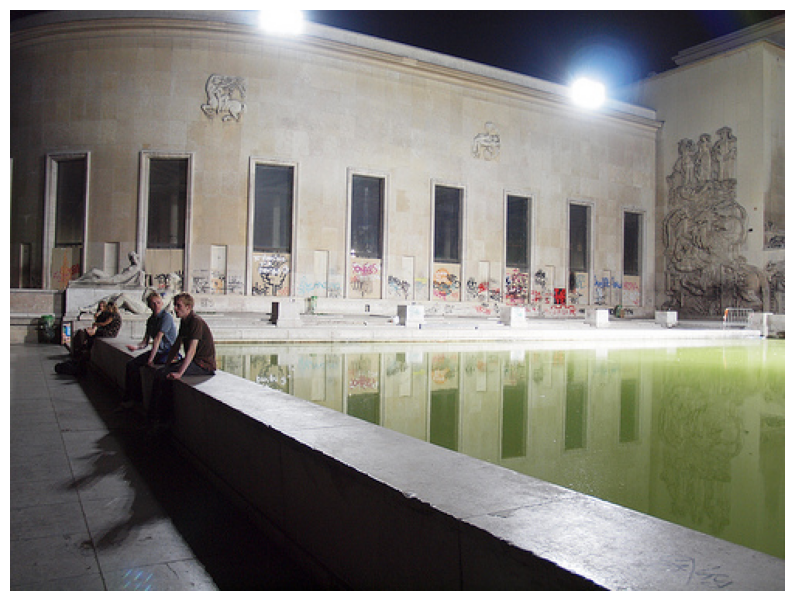

Image: 4070112495.jpg
Greedy: a woman in a white shirt is sitting in a kitchen
Beam (k=3): a woman in a white shirt is sitting at a table
Ground truth:
   • girl dressed up as a black cat stands next to monitor .
   • a girl in a kitten costume stands near shelving .
   • a girl in a cat costume standing in an office .


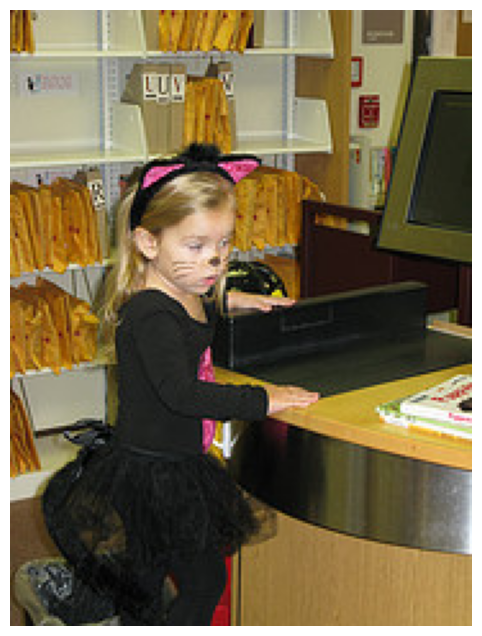

Image: 2491097111.jpg
Greedy: a man in a white shirt and a woman in a white shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and a woman in a black shirt and
Beam (k=3): a group of people are walking down a street
Ground truth:
   • two friends are walking down the street engaged in a lively conversation .
   • three women are walking on the sidewalk with bags in their hands .
   • two ladies with shopping bags walking down the sidewalk laughing .


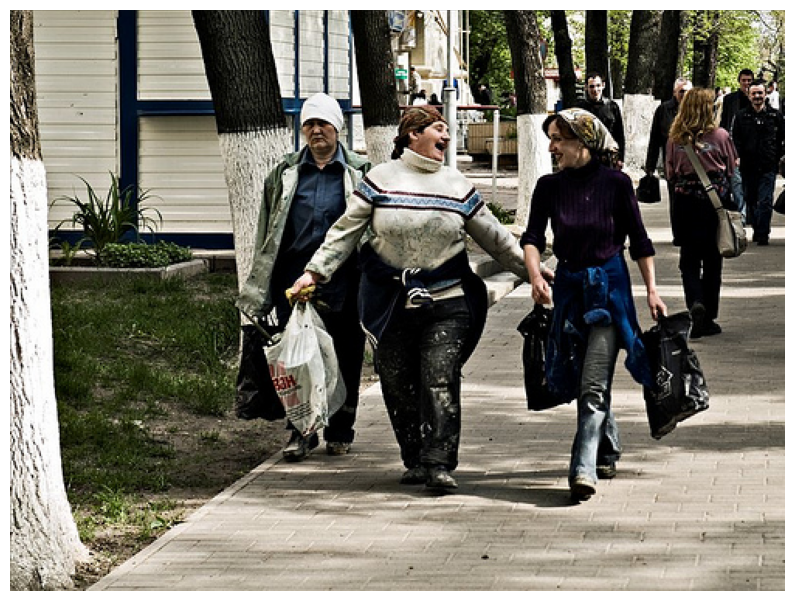

Image: 8180474484.jpg
Greedy: a man is driving a dirt car
Beam (k=3): a man is driving in the air
Ground truth:
   • " a car drives through a muddy area on a dirt track , spraying water and mud everywhere ."
   • toyota rally car plows through a deep puddle of mud on the race course .
   • a race car sprays mud as it comes down a dirt track .


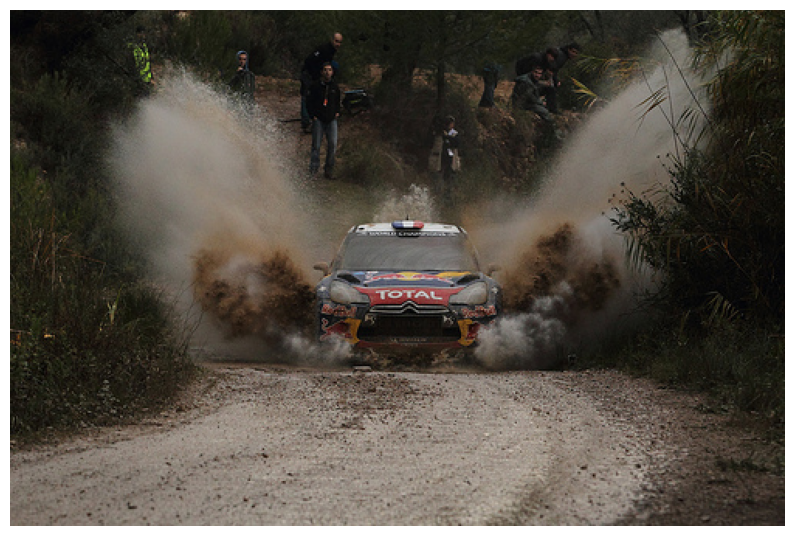

Image: 2711720095.jpg
Greedy: a man in a red jacket is standing on a rock
Beam (k=3): a man in a red jacket is standing on a rock
Ground truth:
   • a man with a lot of camera gear stands in front of a mountain scene .
   • a photographer is standing on a mountain with gear in hand .
   • a man wearing a black coat and red hat holds a camera .


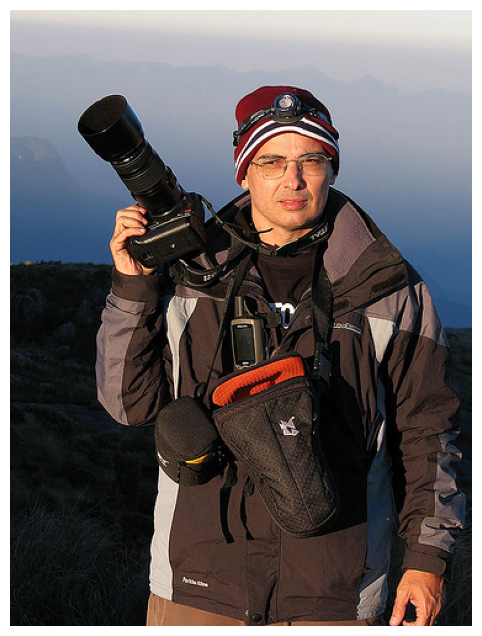

In [13]:
# -------------------------------
# 15. TEST INFERENCE ON SAMPLE IMAGES
# -------------------------------
def show_sample_with_caption(img_name):
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')

    # Get features
    feat = features[img_name][np.newaxis, ...]  # shape (1, 2048)

    # Generate captions
    caption_greedy = generate_caption(model, feat, tokenizer, max_caption_length, method="greedy")
    caption_beam   = generate_caption(model, feat, tokenizer, max_caption_length, method="beam")

    print(f"Image: {img_name}")
    print(f"Greedy: {caption_greedy}")
    print(f"Beam (k=3): {caption_beam}")
    print("Ground truth:")
    for c in image_captions[img_name][:3]:
        print(f"   • {c}")
    plt.show()

# Test on 5 random images
import random
test_images = random.sample(list(features.keys()), 5)
for img in test_images:
    show_sample_with_caption(img)

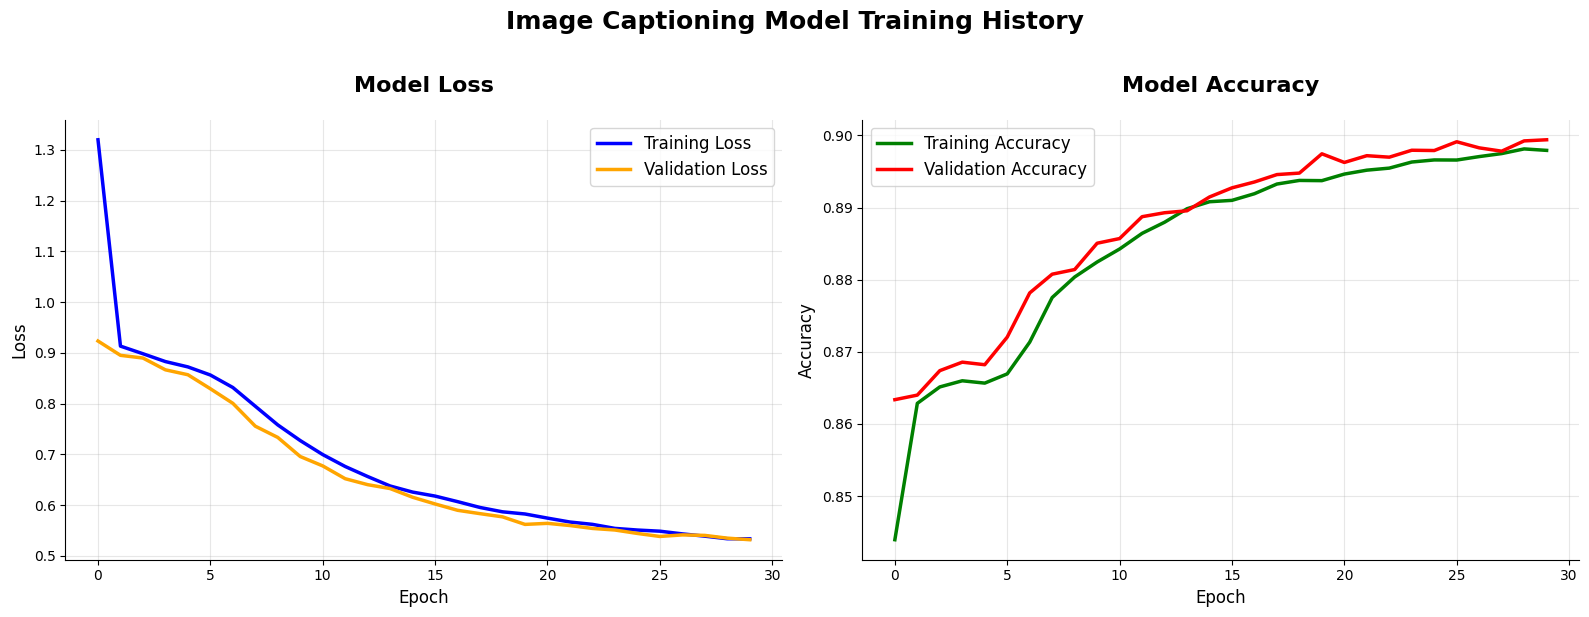

Final Training Loss:     0.5334
Final Validation Loss:   0.5317
Best Validation Loss:    0.5317 (at epoch 30)
Final Training Acc:      0.8979
Final Validation Acc:    0.8994


In [14]:
# -------------------------------
# 18. PLOT TRAINING HISTORY (Fixed & Beautiful)
# -------------------------------
import matplotlib.pyplot as plt

# Fix the subplot creation (was backwards!)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Loss Plot ---
ax1.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2.5)
ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2.5)
ax1.set_title('Model Loss', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- Accuracy Plot ---
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='green', linewidth=2.5)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2.5)
ax2.set_title('Model Accuracy', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Overall title
plt.suptitle('Image Captioning Model Training History', fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss:     {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss:   {history.history['val_loss'][-1]:.4f}")
print(f"Best Validation Loss:    {min(history.history['val_loss']):.4f} (at epoch {np.argmin(history.history['val_loss'])+1})")
print(f"Final Training Acc:      {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Acc:    {history.history['val_accuracy'][-1]:.4f}")